# Cancer Prediction from Scratch: the good, the bad and the ugly 

The notebook is made to demonstrate the next skills:

- Perform proper data preprocessing.
- Descriptive Analytics
- Predictive Analytics
- Perform natural language processing.
- Use map and reduce operations.
- Use streaming data.
- Translate data into a graph and extract information from a network.
- Apply machine learning
- My ability to detect and handle imabalanced data.
- Data Reduction using the PCA algorithm (The Principal Component Analysis)
- Data Visualization with Matplotlib

*From my point of view the application of graph theory is very handy to improve logistics in companies. Specially if we are talking about analyzing information from point A to point B.

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk.sentiment.util
from nltk.tag import pos_tag
import networkx as nx
import itertools
import random
import imblearn
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from pyspark.sql import SparkSession
from sklearn.decomposition import TruncatedSVD
import seaborn as sb
import matplotlib.pyplot as plt
from clustergrammer_widget import *
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
import re

C:\Users\g1238\AppData\Local\conda\conda\envs\DL4Denv\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


 # Cancer Gene Detection
 
 To start coding. I am going to discuss a little bit about the idea behind the scence. I took this dataset available online which has the interactions within human proteins. I am interested in finding out those proteins which are more related to cancer given certain characteristics of the interaction network, to do this I need to detect whether the description containing the word cancer relates positively or negatively to the protein description, in order to classify them as cancer/no cancer(sentiment analysis). Then I am going to do natural language processing to add certain caracteristics given the protein description as an attribute to the node. Afterwards, I am going to proceed to perform some machine learning algorithm to find out those proteins interactions which tend to be, more exposed to turn into cancer given the characteristics of my network.

### Dataset

I took the dataset from the next link https://string-db.org/cgi/download?sessionId=%24input-%3E%7BsessionId%7D&species_text=Homo+sapiens, which takes into account only those proteins from Humans. I do have a list of links with the proteins and their interactions, together with their ID's and descriptions, I will try to find out the cancer labels by doing sentiment analysis over the descriptions. 
   a) First dataset contains the proteins with its descriptions.
   b) Second dataset contains the protein interactions. 

In [3]:
#First Clean the file with the information of each protein.
proteinsInfoOriginal = open("9606.protein.info.v11.0.txt", "r").readlines()

In [4]:
#Second dataset with protein interactions
proteinNetwork = pd.read_csv('9606.protein.links.detailed.v11.0.txt', sep=' ', header='infer')

### NATURAL LANGUAGE PROCESSING: ASSINGING THE LABELS 

I am going to use sentiment analysis over the descriptions to try to detect those descriptions, which I consider to be cancer in negative way. Because, the dataset does not have any label. I want to be able to classify my descriptions in malign cancer.  

In [5]:
#Creating dataset into dataframe.
stopwords = set(nltk.corpus.stopwords.words('english'))

def edit_line(line):
    return str(line).split("\t")
def clean_punc(text):
    return re.sub('[^A-Za-z0-9]+',' ',text.lower())
def clean_num(text):
    return re.sub(r'\d+','',text)
def tokenization(txt):
    return word_tokenize(str(txt).lower())
def stopwords_txt(text):
    return [w for w in text if not w in list(stopwords)]
def lemmatization(txt):
    return [WordNetLemmatizer().lemmatize(t) for t in txt]
def contains_cancer(txt):
    if 'cancer' in txt:
        label = 1
    else: 
        label = 0
    return label
# The ugliness in the next three definitions can be explain as the computer does not support to retrieve all at one time.
def get_desc_sentiment_neg(desc):
    sentiment = SentimentIntensityAnalyzer()
    cancer_sent = sentiment.polarity_scores(desc)
    return cancer_sent['neg']
def get_desc_sentiment_neu(desc):
    sentiment = SentimentIntensityAnalyzer()
    cancer_sent = sentiment.polarity_scores(desc)
    return cancer_sent['neu']
def get_desc_sentiment_pos(desc):
    sentiment = SentimentIntensityAnalyzer()
    cancer_sent = sentiment.polarity_scores(desc)
    return cancer_sent['pos']

data = list(map(edit_line,proteinsInfoOriginal))

In [6]:
data_df = pd.DataFrame(data)
proteinDescription = pd.DataFrame(data_df.iloc[1:])
proteinDescription.columns = data_df.iloc[0]
proteinDescription = proteinDescription.reset_index()
del proteinDescription['index']

Start NLP pipeline.

In [7]:
# Clean punctuation from text
proteinDescription['annotation\n'] = list(map(clean_punc,proteinDescription['annotation\n']))

In [8]:
# Clean numbers from text
proteinDescription['annotation\n'] = list(map(clean_num,proteinDescription['annotation\n']))

In [9]:
# Tokenize text
proteinDescription['nlp_processing'] = list(map(tokenization,proteinDescription['annotation\n']))

In [10]:
# Erase stop words
proteinDescription['nlp_processing'] = list(map(stopwords_txt,proteinDescription['nlp_processing']))

In [11]:
# Apply lemmatization
proteinDescription['nlp_processing'] = list(map(lemmatization,proteinDescription['nlp_processing']))

In [12]:
# Get cancer noun
proteinDescription['cancer_noun_identification'] = list(map(contains_cancer,proteinDescription['nlp_processing']))

In [13]:
# According to the findings only 199 descriptions are related to cancer.
cancer_df = proteinDescription[proteinDescription['cancer_noun_identification'] == 1].reset_index()

In [14]:
sentiment = SentimentIntensityAnalyzer()
cancer_sent = sentiment.polarity_scores(cancer_df["annotation\n"][178])

In [15]:
cancer_df['sent_negative'] = list(map(get_desc_sentiment_neg,cancer_df["annotation\n"]))

In [16]:
cancer_df['sent_positive'] = list(map(get_desc_sentiment_pos,cancer_df["annotation\n"]))

In [17]:
cancer_df['sent_neutral'] = list(map(get_desc_sentiment_neu,cancer_df["annotation\n"]))

In [18]:
cancer_df

,index,protein_external_id,preferred_name,protein_size,annotation,nlp_processing,cancer_noun_identification,sent_negative,sent_positive,sent_neutral
0,102,9606.ENSP00000064778,FAM168A,244,protein fama in cancer context protects cells ...,"[protein, fama, cancer, context, protects, cel...",1,0.261,0.050,0.690
1,156,9606.ENSP00000167106,VASH1,365,vasohibin angiogenesis inhibitor inhibits mig...,"[vasohibin, angiogenesis, inhibitor, inhibits,...",1,0.221,0.059,0.720
2,241,9606.ENSP00000201031,TFAP2C,450,transcription factor ap gamma sequence specif...,"[transcription, factor, ap, gamma, sequence, s...",1,0.052,0.037,0.911
3,441,9606.ENSP00000216807,BRMS1L,323,breast cancer metastasis suppressor like prot...,"[breast, cancer, metastasis, suppressor, like,...",1,0.314,0.120,0.566
4,514,9606.ENSP00000219022,OLFM4,510,olfactomedin may promote proliferation of pan...,"[olfactomedin, may, promote, proliferation, pa...",1,0.135,0.160,0.706
5,589,9606.ENSP00000220812,DKK4,224,dickkopf related protein antagonizes canonica...,"[dickkopf, related, protein, antagonizes, cano...",1,0.120,0.080,0.800
6,815,9606.ENSP00000226230,TMEM97,176,sigma intracellular receptor intracellular or...,"[sigma, intracellular, receptor, intracellular...",1,0.057,0.086,0.857
7,891,9606.ENSP00000228865,CREBL2,120,camp responsive element binding protein like ...,"[camp, responsive, element, binding, protein, ...",1,0.045,0.128,0.828
8,999,9606.ENSP00000231656,CDX1,265,homeobox protein cdx plays a role in transcri...,"[homeobox, protein, cdx, play, role, transcrip...",1,0.162,0.081,0.756
9,1065,9606.ENSP00000233948,WNT6,365,protein wnt ligand for members of the frizzle...,"[protein, wnt, ligand, member, frizzled, famil...",1,0.110,0.037,0.853


In [19]:
cancer_df['cancer'] = np.where((cancer_df['sent_negative'] > cancer_df['sent_positive']) & (cancer_df['sent_negative'] > cancer_df['sent_neutral']),[1],[0])

In [20]:
cancer_df

,index,protein_external_id,preferred_name,protein_size,annotation,nlp_processing,cancer_noun_identification,sent_negative,sent_positive,sent_neutral,cancer
0,102,9606.ENSP00000064778,FAM168A,244,protein fama in cancer context protects cells ...,"[protein, fama, cancer, context, protects, cel...",1,0.261,0.050,0.690,0
1,156,9606.ENSP00000167106,VASH1,365,vasohibin angiogenesis inhibitor inhibits mig...,"[vasohibin, angiogenesis, inhibitor, inhibits,...",1,0.221,0.059,0.720,0
2,241,9606.ENSP00000201031,TFAP2C,450,transcription factor ap gamma sequence specif...,"[transcription, factor, ap, gamma, sequence, s...",1,0.052,0.037,0.911,0
3,441,9606.ENSP00000216807,BRMS1L,323,breast cancer metastasis suppressor like prot...,"[breast, cancer, metastasis, suppressor, like,...",1,0.314,0.120,0.566,0
4,514,9606.ENSP00000219022,OLFM4,510,olfactomedin may promote proliferation of pan...,"[olfactomedin, may, promote, proliferation, pa...",1,0.135,0.160,0.706,0
5,589,9606.ENSP00000220812,DKK4,224,dickkopf related protein antagonizes canonica...,"[dickkopf, related, protein, antagonizes, cano...",1,0.120,0.080,0.800,0
6,815,9606.ENSP00000226230,TMEM97,176,sigma intracellular receptor intracellular or...,"[sigma, intracellular, receptor, intracellular...",1,0.057,0.086,0.857,0
7,891,9606.ENSP00000228865,CREBL2,120,camp responsive element binding protein like ...,"[camp, responsive, element, binding, protein, ...",1,0.045,0.128,0.828,0
8,999,9606.ENSP00000231656,CDX1,265,homeobox protein cdx plays a role in transcri...,"[homeobox, protein, cdx, play, role, transcrip...",1,0.162,0.081,0.756,0
9,1065,9606.ENSP00000233948,WNT6,365,protein wnt ligand for members of the frizzle...,"[protein, wnt, ligand, member, frizzled, famil...",1,0.110,0.037,0.853,0


In [21]:
#Evaluation of the method. I am going to annotated which ones are true and which ones not and compare against the reality. 
# Given that I do have only 200 samples.
cancer_df.to_csv('cancer_pred_sent.csv')

In [22]:
cancer_ground_truth = pd.read_csv('cancer_ground_annotator.csv')

In [23]:
# F1 score of predicting with sentiment analysis the actual cancer label
f1 = float(cancer_ground_truth['TP'].sum()) / (float(cancer_ground_truth['TP'].sum()) + 0.5 * (cancer_ground_truth['FP'].sum() + cancer_ground_truth['FN'].sum()))

In [24]:
# Prediting the cancer label with natural language processing was not that useful. I leave as labels the ones assigned by me.
f1

0.25333333333333335

### Data Preprocessing: Working with the graph

In this part of the process, I am going to work with the data available, to build a network and extract properties out of it. There are three different ways to perform the task. In this assignment, I will address all of them to produce a final dataset, where I will have a protein with information about the amount of neighbors, how much information it sends to other proteins, how much information it receives from other proteins, special properties from the nodes (closeness, betweenness and centrality degree) and properties from the transmission action itself (neighborhood, neighborhood_transferred, fusion, cooccurence, homology, coexpression, coexpression_transferred, experiments, experiments_transferred, database, database_transferred, textmining, textmining_transferred, combined_score), which were obtained from the network description dataset. 

The first thing that I am going to do is to, define data frames which contain the nodes and the edges.

In [ ]:
nodes = list(np.array(proteinCancerFinal['protein_external_id']))
edges = list(tuple(np.array(pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False))))
print(type(proteinCancerFinal['protein_external_id']))
pd.DataFrame(proteinCancerFinal['protein_external_id']).to_csv('nodes.csv')
pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False).to_csv("edges.csv")

### Working with the Graph (Part 1): NetworkX Library and GraphFrames

I used first NetworkX library to extract properties from the network. I created a graph with the nodes and edges generated above, and I wanted to extract specific information from the network such as:
- Number of neighbors per node.
- Number of outDegrees per node (number of times that information is sent to another node).
- Number of inDegrees (number of times that information is received from another node).
- Centrality degree (location of the node within the network).
- Special properties from a node for a given network ([betweenness](https://en.m.wikipedia.org/wiki/Betweenness_cetrality) and [closeness](https://neo4j.com/docs/graph-algorithms/current/algorithms/closeness-centrality/))

From the previous information, I inferred that the nodes in the network were around 20,000 and the edges (amount of information transmitted) were 11,000,000.

#### My experience with NetworkX

I used my laptop to extract information from the network at first instant. However, due to the graph extension and the software architecture of the NetworkX library, turned out to be too complex to extract the desire features (centrality degree, closeness and betweenness).

In my studies at TU Delft I learned to use AWS. Thus, I decided to run the code in a AWS Jupyter Notebook with an EMR cluster. For the AWS configuration I used the S3 Bucket, an r3.xlarge instance (good price vs computational power) and a Jupyter Notebook (AWS). My findings were quite negative. Unfortunately, even in the cluster the properties were not extracted. I concluded that, even if the python library is called from a cluster, the computational cost of finding out the properties of each node, in a graph of around 20,000 nodes and 11 million edges turns out to be too complex. The involved library architecture does not support to work with too complex datasets, I will describe NetworkX as a good library for small datasets. The option of using GraphX from spark (well known for big data) does not support the graph property extraction such as closeness, betweenness etc. Thus, I decided to proceed with using pyspark and aggregating the edge data per node with map and reduce operations, using the network dataset (see [Working with the Graph (part2)]). From my personal point of view, finding the properties of the network and the data aggregation from the edge information will be perfect to strongly predict cancer. However, due to the current technology. I ended up using NetworkX only to extract the amount of neighbors per node.

# #TO DO IDENTIFY CLIQUES TO MAKE EFFICIENT THE COMPUTATION OF METRICS AND CHECK WHETHER A CLIQUE MIGHT BE A STRONG INDICATOR OF CANCER. GIVEN THAT I AM IN A NEIGHBORHOOD WITH CANCER, IT IS MORE PROBABLE THAT I DO HAVE CANCER. 

The next cell represents the code on the aws Jupyter Notebook previously configured to work with the EMR cluster. I am going to get the list of proteins which are related directly in a negative way to cancer. I want to map those relationshipt that might be "toxic" in such way that in my protein network those proteins in contact with "cancer proteins" already have cancer in such way that we will be able to identify a cancer relationship. 

In [90]:
cancer = pd.read_csv('cancer.csv',header='infer')

In [91]:
cancer = cancer[['protein_external_id','negative']]

In [92]:
cancer = cancer[cancer['negative'] == -1]

In [93]:
cancer['cancer'] = 1

In [94]:
cancer = cancer[['protein_external_id','cancer']]

In [95]:
cancer.columns = ['protein1','cancer']

In [96]:
proteinNetwork.columns

Index(['protein1', 'protein2', 'neighborhood', 'fusion', 'cooccurence',
       'coexpression', 'experimental', 'database', 'textmining',
       'combined_score'],
      dtype='object')

In [97]:
proteinNetworkCancer = pd.merge(proteinNetwork, cancer, on='protein1', how='left')

In [98]:
cancer2 = cancer[['protein1','cancer']]

In [99]:
cancer2['protein2'] = cancer2['protein1']
cancer2['cancer2'] = cancer2['cancer']

In [100]:
#I have to do in this dirty way because the column renaming was crashing the dataframe. Sorry!
cancer2 = cancer2[['protein2','cancer2']]

In [101]:
proteinNetworkCancer

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,NaN
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,NaN
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,NaN
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,NaN
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,NaN
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,NaN
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,NaN
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,NaN


In [102]:
proteinNetworkCancer = pd.merge(proteinNetworkCancer,cancer2, on='protein2', how='left')

In [103]:
proteinNetworkCancer['cancer_final'] = (proteinNetworkCancer['cancer'] + proteinNetworkCancer['cancer2']).fillna(0)

In [104]:
def input_cancer_val(val):
    check = 0
    if val >= 1:
        check = 1
    else:
        check = 0
    return check
proteinNetworkCancer['cancer_final'] = list(map(input_cancer_val,proteinNetworkCancer['cancer_final']))

In [105]:
proteinNetworkCancer.drop(['cancer','cancer2'], axis=1)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer_final
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,0
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,0


In [106]:
proteinNetworkCancer[proteinNetworkCancer['cancer_final'] == 1]

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer,cancer2,cancer_final
110962,9606.ENSP00000167106,9606.ENSP00000383185,0,0,0,0,0,0,232,232,1.0,1.0,1
110971,9606.ENSP00000167106,9606.ENSP00000282397,0,0,0,0,0,0,289,289,1.0,1.0,1
367033,9606.ENSP00000219022,9606.ENSP00000309572,0,0,0,0,0,0,187,187,1.0,1.0,1
367408,9606.ENSP00000219022,9606.ENSP00000406861,0,0,0,0,0,0,212,212,1.0,1.0,1
426058,9606.ENSP00000220812,9606.ENSP00000233948,0,0,0,0,93,0,641,660,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10750844,9606.ENSP00000442521,9606.ENSP00000379133,0,0,0,0,0,0,259,259,1.0,1.0,1
10750907,9606.ENSP00000442521,9606.ENSP00000379762,0,0,0,61,0,0,233,249,1.0,1.0,1
11297763,9606.ENSP00000473553,9606.ENSP00000287394,0,0,0,64,123,0,50,152,1.0,1.0,1
11297765,9606.ENSP00000473553,9606.ENSP00000334061,0,0,0,63,157,0,0,176,1.0,1.0,1


In [107]:
proteinNetworkCancer.drop(['cancer','cancer2'], axis=1)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer_final
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,0
...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,0


In [108]:
bucket='networkanalysis'
nodes_data = 'nodes.csv'
edges_data = 'edges.csv'
nodes_data = 's3://{}/{}'.format(bucket, nodes_data)
edges_data = 's3://{}/{}'.format(bucket, edges_data)
edges = list(tuple(np.array(pd.read_csv(edges_data).iloc[:,1:])))
nodes = list(pd.read_csv(nodes_data).iloc[:,1]

SyntaxError: unexpected EOF while parsing (<ipython-input-108-0c2e71e44391>, line 7)

Build the graph with networks as nx.

In [109]:
#Create graph object. 
G = nx.MultiDiGraph()
#getting list of nodes
nodes = list(set(proteinNetworkCancer['protein1'].append(proteinNetworkCancer['protein2'])))
#getting list of edgdesmosomees
edges = list(zip(proteinNetworkCancer.protein1, proteinNetworkCancer.protein2))

In [110]:
G.add_nodes_from(nodes)

In [111]:
G.add_edges_from(edges)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [112]:
#print graph properties
print("Number of Nodes " + str(G.number_of_nodes()))
print("Number of Directed Edges: " + str(G.number_of_edges()))

Number of Nodes 19354
Number of Directed Edges: 11759454


In [113]:
#the amount of in_degree, out_degree and neighbors is the same, because this graph is an undirected graph.
#I want to extract the amount of neighbors in the column protein1 to add the neighbors per relationship on the graph.
#I did not proceed on getting the amount of neighbors on the set of nodes and then doing a join because
#it was too expensive to compute and the computer could not perform the left join. 
#I divided my data in such ugly way because the np.split() method works for equally divided arrays. 
#It was necessary to work by chunks of information otherwise I could not compute. 

In [114]:
def get_indegree_node(node):
    return G.in_degree(node)

In [115]:
#I need to use the ugly loop because otherwise is too heavy.
neighbors = []
for item in proteinNetworkCancer['protein1']:
    neighbors.append(get_indegree_node(item))

In [116]:
def get_indegree_node(node):
    return G.in_degree(node)
def get_outdegree_nodes(node):
    return G.out_degree(node)
def get_node_neighbors(node):
    return len(list(G.neighbors(node)))

nodes_indegree = list(map(get_indegree_node,nodes))
nodes_outdegree = list(map(get_outdegree_nodes,nodes))
nodes_neighbors = list(map(get_node_neighbors,nodes))
# Run the below commands in aws and my personal computer for several hours. It never finished.
# Network size 20000 nodes and 11 million edges. 
    
#closenessDict = nx.closeness_centrality(G)
#betweennessDict = nx.betweenness_centrality(G)
#centralityDegreeDict = nx.degree_centrality(G)

In [117]:
#this is only to proof what I wrote above
nodes_information = pd.DataFrame({'node_id':nodes,'indegree':nodes_indegree,'outdegree':nodes_outdegree,'nodes_neighbors':nodes_neighbors})

In [118]:
nodes_information

,node_id,indegree,outdegree,nodes_neighbors
0,9606.ENSP00000386226,1441,1441,1441
1,9606.ENSP00000217652,1389,1389,1389
2,9606.ENSP00000317895,237,237,237
3,9606.ENSP00000360149,326,326,326
4,9606.ENSP00000345968,348,348,348
...,...,...,...,...
19349,9606.ENSP00000354583,156,156,156
19350,9606.ENSP00000344468,526,526,526
19351,9606.ENSP00000346733,738,738,738
19352,9606.ENSP00000222224,127,127,127


In [119]:
len(neighbors)

11759454

BY the numbers obtained above we can infer easly that proteins in a network behave as an undirect graph or the dataset is too synthetic. 

Given the computational cost I only extract the amount of neighbors.

#### My Experience with GraphFrames (Pyspark)

I still wanted to have more network properties to train the machine learning algorithm. Thus, I found out the [ GraphFrames](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#triangle-count) library, which works well with SQL-Pyspark. I used the library to extract the outDegrees and inDegrees and the number of triangles passing to each node. I can describe the library to be quite handy to process bigger files, but still they do not offer the previous mentioned properties (Betweenness, Closenness and Centrality Degree). The reason for that is the complexity involved in computing them. Overall, I extracted a dataset where I had a protein id with outDegrees, inDegrees and the triangle count(pending). 

In [ ]:
from graphframes import * #follow the documentation to open pyspark-shell with graphframes
edges = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/edges.csv")
nodes = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/nodes.csv")
#data cleaning
newedges = edges[["protein1","protein2"]]
newnodes = nodes[["protein_external_id"]]
#change newnodes header to "id" matter of the library graphframe specification. Read documentation.
oldcolumnnodes = newnodes.schema.names
newcolumnnodes = ['id']
newnodes2 = reduce(lambda newnodes, idx: newnodes.withColumnRenamed(oldcolumnnodes[idx], newcolumnnodes[idx]), xrange(len(oldcolumnnodes)), newnodes)
#change edges header to src and dst.
oldcolumnedges = newedges.schema.names
newcolumnedges = ['src', 'dst']
newedges2 = reduce(lambda newedges, idx: newedges.withColumnRenamed(oldcolumnedges[idx], newcolumnedges[idx]), xrange(len(oldcolumnedges)), newedges)
g = GraphFrame(newnodes2,newedges2)
vertexInDegrees = g.inDegrees
vertexOutDegrees = g.outDegrees
vertexOutDegrees.toPandas().to_csv("vertexOutDegrees.csv")
vertexInDegrees.toPandas().to_csv("vertexInDegrees.csv")
triangles = g.triangleCount()
triangles.toPandas().to_csv("vertexTriangles.csv")
#join Data by key, which is equal to the protein tag.
#A_B = A.join(B, A.id == B.id).select(A.*, B.b1, B.b2)
joinedDegrees = vertexInDegrees.join(vertexOutDegrees,vertexOutDegrees.id == vertexInDegrees.id)
#change schema due to id repetition.
oldcolumndegrees = joinedDegrees.schema.names
newcolumndegrees = ['id','inDegree','id1','outDegree']
joinedDegrees2 = reduce(lambda joinedDegrees, idx: joinedDegrees.withColumnRenamed(oldcolumndegrees[idx], newcolumndegrees[idx]), xrange(len(oldcolumndegrees)), joinedDegrees)
#drop id1
pandasclean = joinedDegrees2.toPandas()
pandas = pandasclean[['id','inDegree','outDegree']]
pandas.to_csv('degrees.csv')
#THE INDEGREES AND OUT DEGREES TURN OUT TO BE THE SAME. THIS FACT IS A PROOF OF HOW WONDERFUL
#AND PERFECT THE ENGINEERING NATURE IS. HOWEVER, WHEN WORKING WITH OTHER TYPES OF NETWORKS THE OUTDEGREES AND
#INDEGREES ARE RARELY THE SAME
joinTrianglesVertexIn = triangles.join(vertexInDegrees, vertexInDegrees.id == triangles.id)
joinTrianglesVertexIn.toPandas().to_csv("firstjoin.csv")
secondJoin = rddJoin.join(vertexOutDegrees, vertexOutDegrees.id == rddJoin.id)
secondJoin.toPandas().to_csv("secondJoin.csv")
#*This join operations were done witth rdds, I am aware that it can be done as well by using join alike SQL operations.

#### Information Summary

Thanks to NetworkX, I extracted the neighbors per node.
Thanks to GraphFrames I got the inDegree, outDegree and triangle count for each node.
The resulted format of the dataset is: 

node, number_of_neighbors, outDegree, inDegree, triangle_count.

### Working with the Graph (Part 2): Spark Streaming

The network file was not really big, it had a size of only 1 gb. The problem is that it was too long. Taking into account the hardware side and how registers need a space in a RAM memory to perform operations 11000000 of registers are a problem and cannot be proccessed at once by any small device pay-able by a regular human (Of course until we manage to find out the secrets of the quantum computing, but I will leave that for the future :) ). Thus, I decided to use Spark Streaming. It basically consists in reading your data by chunks of information. In my case, nicely break my long data into small subsets that I can process with spark (each chunk at a time). Below, you can appreciate the code that I created.

My intention with the code below was to produce an aggregation of the "9606.protein.links.full.v11.0.txt"(edge description data) in such way that I will end up producing a dataset including a protein name, plus the sum of each of the mentioned properties per node. In my case, I took into account the information transmitted from protein 1 to protein 2. Thus, I deleted protein 2 column.

In [ ]:
from operator import add, sub
from time import sleep
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from os import walk

sc = SparkContext(appName="streamingProteins")
ssc = StreamingContext(sc,5)
#Reshape Data
file = open("/home/abi/Documents/Network Analysis/9606.protein.links.full.v11.0.txt", "r").readlines()
del file[0]
def cleanStr(str):
    newStr = str.replace("\n","")
    newStr2 = newStr.replace(newStr[21:42],"")
    return newStr2
newFile = map(cleanStr, file)
#write Data to new txt file
with open('proteinTransmission.txt', 'w') as filehandle:
    for item in newFile:
        filehandle.write('%s\n' % item)

#create definition to save outputdata
def saveResults(rdd):
    if not rdd.isEmpty():
        rdd.toDF(["protein1","1","2","3","4","5","6","7","8","9","10","11","12","13","14"]).write.save("rddsprocess", format="csv", mode="append")
#Load proteinTransmission file
proteinTransmission = open("proteinTransmission.csv", "r").readlines()
#create file to store the rdds manually file in the spark folder with name rddsprocess.txt
#create rdd array like = queue 
rddQueue = []
# store in queue the information batches
for batch in proteinTransmission:
    rddQueue += [ssc.sparkContext.parallelize(batch)]

inputStream = ssc.queueStream(rddQueue)
inputStreamSplit = inputStream.map(lambda x: x.split(","))
inputStreamTuple = inputStreamSplit.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
inputStreamInt = inputStreamTuple.map(lambda x: (x[0], [int(i) for i in x[1]]))
totalStream = inputStreamInt.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1], a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],a[12]+b[12],a[13]+b[13],a[14]+b[14]))
totalStream.foreachRDD(saveResults)

scc.start()
scc.awaitTermination()

### Working with the Graph (Part 3): The Rudymentary Way with Pyspark and Map and Reduce Operations

Working with small computer, I decided to break the file (using os), into several files and perform data aggregation over each file to produce a reduced file. Later, I used all the reduced file to produced a second reduction and finally get the aggregated data of the network.

In [ ]:
#Define the amount of lines that my chunk files are going to have 
linesPerFile = 5000
smallfile = None
with open("proteinTransmission.txt") as file:
    for lineno, line in enumerate(file):
        if lineno % linesPerFile == 0:
            if smallfile:
                smallfile.close()
            smallName = "filereduction/smallfile_{}.txt".format(lineno + linesPerFile)
            smallfile = open(smallName, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()
def changestr(str):
    newstr = str.replace("\n","")
    return str
#iteration over the documents to perform map and reduce operation over each of them and print the reduced rdd to 
#a newreducefile.
breakedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction")
for file in breakedData:
    workfile = "filereduction/" + file
    workfilelist = open(workfile, "r").readlines()
    newworkfilelist = map(changestr, workfilelist)
    firstRdd = sc.parallelize(newworkfilelist)
    tupleRDD = firstRdd.map(lambda x: x.split(" "))
    tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
    intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
    #Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
    total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
    newName = "filereduction/reduced/" + "red-" + file.replace("txt","csv")
    df = spark.createDataFrame(total)
    df.toPandas().to_csv(newName)


The output of the previous cell represented the aggregate data of each batch of information. In order to fully aggregate the data, it is necessary to append all the information together and to perform a map and reduce operation again. Each file resulted in a ~20 row key value aggregation.

#### More Data Processing to aggregate the chunks of information.

The cell below is to combine all the reduced files into one reduced file.

In [ ]:
#get the paths from reduced folder
reducedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced")
#create manually a file called result.txt contained in the reduced folder
#save full paths of reduced documents to a list
def updateListPath(pathDoc):
    str = "/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/" + pathDoc
    return str
#Update path list with the full path, initially it only contains the file names.
updated = map(updateListPath,reducedData)

#Append all the txt files together into one txt file.
with open(("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt"),"w") as result:
    for file in updated:
        for line in open(file, "r"):
            result.write(line)

The next code is to reduce all the information in the file. = More map and reduce.

In [ ]:
#Data preprocessing again. Now I had to clean the data again because the spark data frame returned the file with another format.
#load the resulted file and delete rows with unnecessary strings.
reducedDataDf = spark.read.csv("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt")
#delete rows with null values and delete column _c0 index from the previous datasets.
reducedDfDeleteRow = reducedDataDf.filter(reducedDataDf._c0 != 'null').drop(reducedDataDf._c0)
#print the table as csv file to perform text processing over the values.
reducedPandas = reducedDfDeleteRow.toPandas()
noisyTuples = list(reducedPandas["_c2"])
#clean column
def cleanTup(str):
    del1 = str.replace("Row(","")
    del1 = del1.replace("_1=","")
    del2 = del1.replace("_2=","")
    del3 = del2.replace("_3=","")
    del4 = del3.replace("_4=","")
    del5 = del4.replace("_5=","")
    del6 = del5.replace("_6=","")
    del7 = del6.replace("_7=","")
    del8 = del7.replace("_8=","")
    del9 = del8.replace("_9=","")
    del10 = del9.replace("_10=","")
    del11 = del10.replace("_11=","")
    del12 = del11.replace("_12=","")
    del13 = del12.replace("_13=","")
    del14 = del13.replace("_14=","")
    del15 = del14.replace(")","")
    del15 = del15.replace("u'","")
    return del15

clean = map(cleanTup,noisyTuples)
protein = list(reducedPandas['_c1'])
df = pandas.DataFrame(clean,protein)
#print csv ready to perform last step of map and reduce.
df.to_csv("last_step_mp.csv", sep=" ")
#load csv to perform last map and reduce operation.
#clean data again.
file = open("last_step_mp.csv", "r").readlines()

def cleanstr(str):
    str = str.replace(",","")
    str2 = str.replace('"',"")
    str3 = str2.replace("\n","")
    return str3

newFile = map(cleanstr,file)
del newFile[0]

#work with the map and reduce logic.
firstRdd = sc.parallelize(newFile)
tupleRDD = firstRdd.map(lambda x: x.split(" "))
tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
#Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
df = spark.createDataFrame(total).toPandas().to_csv("nodesnetaggregation.csv")

#*Data cleaning might be less complicated by using sql alike tables or Tableau itself.

After performing the map and reduce operations over the values, it was noted that only around 7000 nodes were involved in the network dataset. The result makes sense since all the possible proteins registered with the description are present in the first dataset. Now, I will aggregate the data to link the corresponding network properties with each protein. Overall, the four datasets that I am going to combine are the "neighbors.csv", "degrees.csv","finalData.csv"(cancer label) and the "nodesnetaggregation.csv".

### Aggregating the datasets for the machine learning algorithm (more map and reduce)

In [ ]:
#I cleaned manually the files. Erasing unnecessary columns and renaming columns.
# Creating a string list of the files
degrees = open("degrees.csv", "r").readlines()
neighbors = open("neighbors.csv","r").readlines()
nodesnet = open("nodesnetaggregation.csv").readlines()
cancer = open("finalData.csv").readlines()

# Erasing "\n" from the list of strings
def clean(str):
    newstr2 = str.replace("\n","")
    return newstr2

degreesClean = map(clean,degrees)
neighborsClean = map(clean,neighbors)
nodesnetClean = map(clean,nodesnet)
cancerClean = map (clean,cancer)
del degreesClean[0]
del neighborsClean[0]
del nodesnetClean[0]
del cancerClean[0]
# Creating first rdd of strings
degreesRdd = sc.parallelize(degreesClean)
neighborsRdd = sc.parallelize(neighborsClean)
nodesnetRdd = sc.parallelize(nodesnetClean)
cancerRdd = sc.parallelize(cancerClean)

# Spliting first rdd by ","
degreesRddSch =  degreesRdd.map(lambda x: x.split(","))
neighborsRddSch = neighborsRdd.map(lambda x: x.split(","))
nodesnetRddSch = nodesnetRdd.map(lambda x: x.split(","))
cancerRddSch = cancerRdd.map(lambda x: x.split(","))

# Turn tuple RDD to data frame.
degreesTuple = degreesRddSch.map(lambda x: (x[0],(x[1],x[2])))
neighborsTuple = neighborsRddSch.map(lambda x: (x[0],x[1]))
nodesnetTuple = nodesnetRddSch.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
cancerTuple = cancerRddSch.map(lambda x: (x[0],x[1]))
# Performing join operations over the RDDs.
nodesdeg = nodesnetTuple.join(degreesTuple)
#Transform to data frames the rdds.
nodesnetDf = nodesnetTuple.toDF()
degreesDf = degreesTuple.toDF()
neighborsDf = neighborsTuple.toDF()
cancerDf = cancerRddSch.toDF()
#write union read file back clean data and create tuple rdd
nodesDeg = nodesnetDf.join(degreesDf, nodesnetDf._1 == degreesDf._1).select(nodesnetDf["*"],degreesDf["_2"])
nodesDegNeig = nodesDeg.join(neighborsDf, nodesDeg._1 == neighborsDf._1).select(nodesDeg["*"], neighborsDf["_2"])
nodesDegNeigCan = nodesDegNeig.join(cancerDf, nodesDegNeig._1 == cancerDf._1).select(nodesDegNeig["*"], cancerDf["_2"])
#Now we had a dataset with the form of protein Id, netproperties, indegrees, out degrees, amount of neighbors and cancer
#I will print it and clean it again.
#9606.ENSP00000257013	Row(_1=u'0', _2=u'0', _3=u'0', _4=u'0', _5=u'3628', _6=u'7274', _7=u'239', _8=u'1874', _9=u'0', _10=u'0', _11=u'0', _12=u'1132', _13=u'7225', _14=u'34034')	Row(_1=u'135', _2=u'135')	135	0
nodesDegNeigCan.toPandas().to_csv("mlpreviousfinal.csv")
#manually delete first row

### Welcome to the soup: Data Cleaning to get our final dataset to perform the SVM algorithm.

In this part, what I am going to do is preprocessing the output file again from the previous step to give it a shape of a proper matrix, for applying the machine learning algorithm. Afterwards, I am going to normalize the data and perform a PCA analysis, to find out the components/features that are valuable enough to be used in the machine learning algorithm. The principal component analysis algorithm is well known to be used as feature reduction. 

In [ ]:
#Load the dataset as a list of strings
datasemiFinal = open("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/mlpreviousfinal.csv","r").readlines()
#Clean the ugly string again T_T
'9606.ENSP00000257013,"Row(_1=u\'0\', _2=u\'0\', _3=u\'0\', _4=u\'0\', _5=u\'3628\', _6=u\'7274\', _7=u\'239\', _8=u\'1874\', _9=u\'0\', _10=u\'0\', _11=u\'0\', _12=u\'1132\', _13=u\'7225\', _14=u\'34034\')","Row(_1=u\'135\', _2=u\'135\')",135,0\n'
def cleanStr(str):
    newstr = str.replace('"',"")
    str1 = newstr.replace('\'',"")
    str2 = str1.replace("Row(","")
    str3 = str2.replace("_2=u","")
    str4 = str3.replace("_3=u","")
    str5 = str4.replace("_4=u","")
    str6 = str5.replace("_5=u","")
    str7 = str6.replace("_6=u","")
    str8 = str7.replace("_7=u","")
    str9 = str8.replace("_8=u","")
    str10 = str9.replace("_9=u","")
    str11 = str10.replace("_10=u","")
    str12 = str11.replace("_11=u","")
    str13 = str12.replace("_12=u","")
    str14 = str13.replace("_13=u","")
    str15 = str14.replace("_14=u","")
    str16 = str15.replace("Row(_1=u","")
    str17 = str16.replace("_2=u","")
    str18 = str17.replace('\')"',"")
    str19 = str18.replace("\n","")
    str20 = str19.replace(")","")
    str21 = str20.replace("_1=u","")
    return str21
datasemiFinalClean = map(cleanStr,datasemiFinal)
#Turn into rdd to gave it a shape
datasemiRdd = sc.parallelize(datasemiFinalClean).map(lambda x: x.split(","))
#Turn into pandas csv and print.
datasemiRdd.toDF().toPandas().to_csv("machineLearningReady.csv")
#manually configure column names according to previous steps.

After writing manually columns the machineLearningReady.csv. Has the columns in the format below:
- id
- neighborhood
- neighborhoodTransferred
- fusion 
- coocurence
- homology
- coexpression
- coexpressionTransferred
- experiments
- experimentsTransferred
- database
- databaseTransferred
- combinedScores
- neighbors
- inDegree
- outDegree
- cancer


## Machine Learning Part

### Descriptive Analytics: Dataset Exploration

First of all, my data is too much for my computer. Thus, I am going to explore the dataset with some descritive analytics and then I am going to take a sample from my data. 

In [120]:
#I am going to create my extra attribute with a for loop because any other method is too heavy for computation
proteinNetworkCancer['neighbors'] = neighbors

In [121]:
dataMl = proteinNetworkCancer

In [122]:
dataMl

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,cancer,cancer2,cancer_final,neighbors
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,NaN,NaN,0,1662
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,NaN,NaN,0,1662
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,NaN,NaN,0,1662
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,NaN,NaN,0,1662
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,NaN,NaN,0,1662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,NaN,NaN,0,100
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,NaN,NaN,0,100
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,NaN,NaN,0,100
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,NaN,NaN,0,100


### Proportions

I will check how is the proportion of 1 and 0 on my depending variable to check if I am in a problem with imbalanced data. 

In [6]:
#save the data to csv, because the kernel is constantly dying. 
#dataMl.to_csv('cancer_data.csv')
dataMl = pd.read_csv('cancer_data.csv', sep=',', header='infer')

In [7]:
del dataMl['Unnamed: 0']
del dataMl['Unnamed: 0.1']
dataMl

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,neighbors,cancer
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,1662,0
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,1662,0
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,1662,0
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,1662,0
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,1662,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,100,0
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,100,0
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,100,0
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,100,0


In [8]:
dataMl_pos = dataMl[dataMl['cancer'] == 1]

In [9]:
dataMl_neg = dataMl[dataMl['cancer'] == 0]

In [10]:
cancer_pos = float(len(dataMl_pos))/float(len(dataMl))

In [11]:
cancer_neg = float(len(dataMl_neg))/float(len(dataMl))

In [12]:
cancer_neg

0.999983672711335

In [13]:
cancer_pos

1.6327288664932914e-05

As we can appreciate it is a clearly anomaly detection case where our negative label is less than 1% of our data. I am going to proceed to check some descriptive analtics over the variables and later on perform an oversampling method only on our negative class. I choose the oversampling over the negative class, because I am interested in been able to detect the negative class. Furthermore, I am not doing any undersampling method on the postive class because I do not want to break the patterns created by the network naturally. 

* Neighborhood attributes: I am extracting the maximum and minimum values to get an idea what it will be a good size for the bins in my histogram to analyze distribution.

In [14]:
max_val_neigh = dataMl['neighborhood'].max()

In [15]:
min_val_neigh = dataMl['neighborhood'].min()

In [16]:
std_val_negih = dataMl['neighborhood'].std()

In [17]:
mean_val_neigh = dataMl['neighborhood'].mean()

In [18]:
max_val_neigh

385

In [19]:
min_val_neigh

0

In [20]:
std_val_negih

20.5037852888835

In [21]:
mean_val_neigh

3.187574355067846

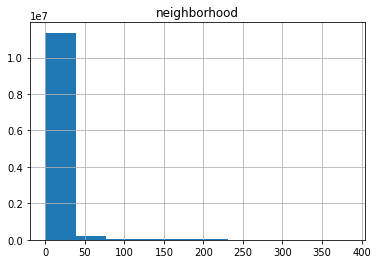

In [22]:
dataMl.hist(column='neighborhood', bins=10);

* Fusion attributes

In [23]:
max_val_fus = dataMl['fusion'].max()

In [24]:
min_val_fus = dataMl['fusion'].min()

In [25]:
std_val_fus = dataMl['fusion'].std()

In [26]:
mean_val_fus = dataMl['fusion'].mean()

In [27]:
max_val_fus

900

In [28]:
min_val_fus

0

In [29]:
std_val_fus

7.620421168353864

In [30]:
mean_val_fus

0.16457702883144065

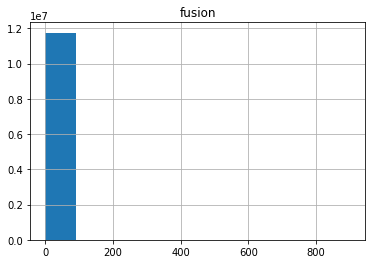

In [31]:
dataMl.hist(column='fusion', bins=10);

* Cooccurence attributes

In [32]:
max_val_coo = dataMl['cooccurence'].max()

In [33]:
min_val_coo = dataMl['cooccurence'].min()

In [34]:
std_val_coo = dataMl['cooccurence'].std()

In [35]:
mean_val_fus = dataMl['cooccurence'].mean()

In [36]:
max_val_coo

448

In [37]:
min_val_coo

0

In [38]:
std_val_coo

13.466937620097767

In [39]:
mean_val_fus

0.8819394165749532

array([[<AxesSubplot:title={'center':'cooccurence'}>]], dtype=object)

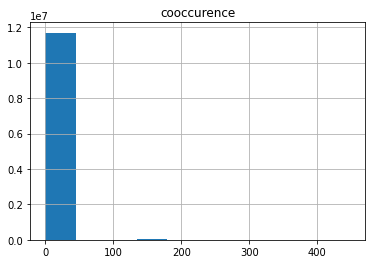

In [40]:
dataMl.hist(column='cooccurence')

* Coexpression attributes

In [41]:
max_val_coe = dataMl['coexpression'].max()

In [42]:
min_val_coe = dataMl['coexpression'].min()

In [43]:
std_val_coe = dataMl['coexpression'].std()

In [44]:
mean_val_coe = dataMl['coexpression'].mean()

In [45]:
max_val_coe

999

In [46]:
min_val_coe

0

In [47]:
std_val_coe

97.58623059797844

In [48]:
mean_val_coe

60.211073065127

array([[<AxesSubplot:title={'center':'coexpression'}>]], dtype=object)

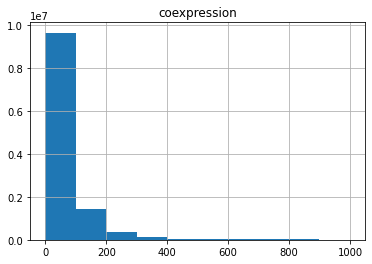

In [49]:
dataMl.hist(column='coexpression')

* Experimental attributes

In [50]:
max_val_exp = dataMl['experimental'].max()

In [51]:
min_val_exp = dataMl['experimental'].min()

In [52]:
std_val_exp = dataMl['experimental'].std()

In [53]:
mean_val_exp = dataMl['experimental'].mean()

In [54]:
max_val_exp

999

In [55]:
min_val_exp

0

In [56]:
std_val_exp

118.82915600957516

In [57]:
mean_val_exp

68.34279346643135

array([[<AxesSubplot:title={'center':'experimental'}>]], dtype=object)

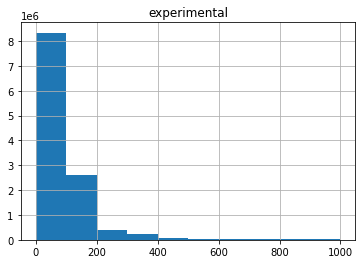

In [58]:
dataMl.hist(column='experimental')

* Database Attributes: For this particular attribute, I will leave it as unique values with its frequencies, 

In [59]:
dataMl['database'].unique()

array([  0, 900, 650, 800, 600, 540, 360, 720])

In [60]:
dataMl['database'].value_counts()

0      11053014
900      604362
600       30592
540       17986
650       17972
800       16150
720        9772
360        9606
Name: database, dtype: int64

* Textmining attributes

In [61]:
max_val_txt = dataMl['textmining'].max()

In [62]:
min_val_txt = dataMl['textmining'].min()

In [63]:
std_val_txt = dataMl['textmining'].std()

In [64]:
mean_val_txt = dataMl['textmining'].mean()

In [65]:
max_val_txt

993

In [66]:
min_val_txt

0

In [67]:
std_val_txt

149.22899651855138

In [68]:
mean_val_txt

170.136070603278

array([[<AxesSubplot:title={'center':'textmining'}>]], dtype=object)

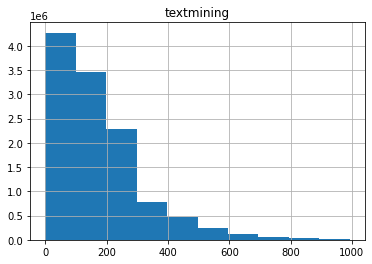

In [69]:
dataMl.hist(column='textmining')

* Combined_score attributes

In [70]:
max_val_comb = dataMl['combined_score'].max()

In [71]:
min_val_comb = dataMl['combined_score'].min()

In [72]:
std_val_comb = dataMl['combined_score'].std()

In [73]:
mean_val_comb = dataMl['combined_score'].mean()

In [74]:
max_val_comb

999

In [75]:
min_val_comb

150

In [76]:
std_val_comb

197.15931208847724

In [77]:
mean_val_comb

295.8066422131504

array([[<AxesSubplot:title={'center':'combined_score'}>]], dtype=object)

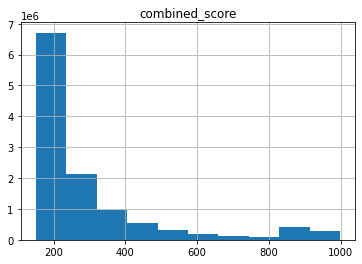

In [78]:
dataMl.hist(column='combined_score')

* Neighbors attributes

In [79]:
max_val_neigh = dataMl['neighbors'].max()

In [87]:
min_val_neigh = dataMl['neighbors'].min()

In [88]:
std_val_neigh = dataMl['neighbors'].std()

In [89]:
mean_val_neigh = dataMl['neighbors'].mean()

In [90]:
max_val_neigh

7645

In [91]:
min_val_neigh

1

In [92]:
std_val_neigh

790.0866039459232

In [93]:
mean_val_neigh

1067.936830230383

array([[<AxesSubplot:title={'center':'neighbors'}>]], dtype=object)

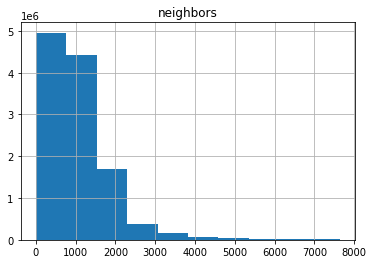

In [94]:
dataMl.hist(column='neighbors')

# Feature Engineering 

Giving the descriptive analytics from above, I will consider the next situation. I do have good variability in my data on the feature "neighbors", "combined_score" and "textmining". I decided to extract the IQR from these features and perform a substraction operation to locate how far the register is from the IQR and use it as an extra feature to detect whether the register belongs to cancer positive label.

In [113]:
Q1_neigh = dataMl['neighbors'].quantile(0.25)

In [114]:
Q3_neigh = dataMl['neighbors'].quantile(0.75)

In [115]:
IQR_neigh = Q3_neigh - Q1_neigh

In [116]:
IQR_neigh

859.0

In [117]:
neighbors_dev = Q3_neigh = dataMl['neighbors'] - IQR_neigh

In [118]:
Q1_comb = dataMl['combined_score'].quantile(0.25)

In [119]:
Q3_comb = dataMl['combined_score'].quantile(0.75)

In [120]:
IQR_comb = Q3_comb - Q1_comb

In [121]:
IQR_comb

140.0

In [122]:
combined_score_dev = dataMl['combined_score'] - IQR_comb

In [123]:
Q1_txt = dataMl['textmining'].quantile(0.25)

In [124]:
Q3_txt = dataMl['textmining'].quantile(0.75)

In [125]:
IQR_txt = Q3_txt - Q1_txt

In [126]:
IQR_txt

174.0

In [127]:
textmining_dev = dataMl['textmining'] - IQR_comb

In [129]:
predictor = dataMl['cancer']

In [131]:
del dataMl['cancer']

In [133]:
dataMl['neighbors_dev'] = neighbors_dev

In [134]:
dataMl['combined_score_dev'] = combined_score_dev

In [135]:
dataMl['textmining_dev'] = textmining_dev

In [136]:
dataMl['cancer'] = predictor

# Apply Label encoding and normalization

Given that I do have around 20000 different kind of protein names, I decided to apply a label encoder instead of one hot encoder, due to my computational issues, it will make my data to grow a lot. 

In [137]:
label_prot1 = preprocessing.LabelEncoder() 
dataMl['protein1']= label_prot1.fit_transform(dataMl['protein1']) 
#print(block['Gender'].unique())

In [139]:
label_prot2 = preprocessing.LabelEncoder() 
dataMl['protein2'] = label_prot2.fit_transform(dataMl['protein2'])

In [152]:
encoder_columns = dataMl[['protein1','protein2']]
encoder_columns['index_'] = encoder_columns.index

<ipython-input-152-594595a18b85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoder_columns['index_'] = encoder_columns.index


In [142]:
number_columns = dataMl.iloc[:,2:-1]

In [145]:
scaler = MinMaxScaler()
numerical_data = pd.DataFrame(scaler.fit_transform(number_columns),columns=number_columns.columns, index=number_columns.index) 

In [160]:
numerical_data['index_'] = numerical_data.index

In [161]:
dataMl_prep = encoder_columns.join(numerical_data.set_index('index_'), on='index_')

In [165]:
del dataMl_prep['index_']

In [166]:
dataMl_prep

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,neighbors,neighbors_dev,combined_score_dev,textmining_dev
0,0,3469,0.0,0.0,0.741071,0.062062,0.181181,0.0,0.125881,0.400471,0.217295,0.217295,0.400471,0.125881
1,0,1759,0.0,0.0,0.000000,0.000000,0.186186,0.0,0.056395,0.056537,0.217295,0.217295,0.056537,0.056395
2,0,15599,0.0,0.0,0.000000,0.000000,0.159159,0.0,0.000000,0.010601,0.217295,0.217295,0.010601,0.000000
3,0,16415,0.0,0.0,0.000000,0.061061,0.158158,0.0,0.545821,0.537102,0.217295,0.217295,0.537102,0.545821
4,0,7401,0.0,0.0,0.000000,0.088088,0.078078,0.0,0.089627,0.020024,0.217295,0.217295,0.020024,0.089627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11759449,19353,6045,0.0,0.0,0.000000,0.167167,0.000000,0.0,0.000000,0.020024,0.012951,0.012951,0.020024,0.000000
11759450,19353,8702,0.0,0.0,0.000000,0.175175,0.000000,0.0,0.000000,0.029446,0.012951,0.012951,0.029446,0.000000
11759451,19353,9464,0.0,0.0,0.000000,0.195195,0.000000,0.0,0.000000,0.053004,0.012951,0.012951,0.053004,0.000000
11759452,19353,12477,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.883392,0.012951,0.012951,0.883392,0.000000


In [168]:
dataMl_prep['cancer'] = predictor

In [171]:
#dataMl_prep.to_csv('cancer_data_prep.csv') #save dataset to use it the next time. 

# Dealing with Imbalanced Data

In order to make sure that the predictions are made properly, it is needed to know how our data looks. For example, if we have too few cancer properties, we will need to create a homogeneous dataset in order to test the algorithm. Otherwise, it might be biased due to the skewed data. The same case occurs in the anomaly detection for credit cards fraud, cases where the anomalies turn out to be around 5% or 2% of the total amount of data. 
Therefore, from the Machine Learning Dataset we want to identify how many positive cancer proteins do we have. 

After filtering the cancer proteins, I found out that only 129 are cancer out of 11474579. That makes our data highly imbalanced, only 1.6327288664932914e-05% of the proteins represent cancer. There will be a need to use SMOTE (Synthetic Minority Over-sampling Technique) to give homogeneity to our dataset. According to [Imbalanced Learning](https://imbalanced-learn.org/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py) we will need to apply the oversampling method to increase our skewed cancer data and an undersampling method to clean the noise generated on data. 

In [3]:
dataMl_prep = pd.read_csv('cancer_data_prep.csv', sep=',', header='infer')

In [4]:
del dataMl_prep['Unnamed: 0']

In [5]:
x_res = dataMl_prep.iloc[:,:-1]
y_res = dataMl_prep.iloc[:,-1]

In [6]:
#Perform resample minority
#Increase the skewed cancer data to 20%.
smote = SMOTE(sampling_strategy = 0.2)
x_smt, y_smt = smote.fit_resample(x_res,y_res)

### Data Exploration: Variable Visualization

Here I would like to demonstrate the visualization of the feature values against the proteins with a heatmap.

In [ ]:
dfVisualization = pd.DataFrame(dataMl.iloc[:,0])
dfNormalization = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[:,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual = pd.concat([dfVisualization,dfNormalization], axis=1, sort=False).dropna()
del dfVisual["delete"]
#net = Network(clustergrammer_widget)
vis = dfVisual.iloc[:,1:].values
cols = np.array(dfVisual['id'])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs = pd.DataFrame(vis.T, index = ind, columns = cols)
vs.T.to_csv('vs_explore.csv')
plt.pcolor(vs)
plt.yticks(np.arange(0.5, len(vs.index), 1), vs.index)
plt.xticks(np.arange(0.5, len(vs.columns), 1), vs.columns, rotation=90)
plt.show()

The visualization above displays the 7000 proteins with its corresponding values. The reader cannot really infer from the plot, how the cancer looks. Thus, below I sliced information in chunks of 25 proteins to be able to compare cancer against regular proteins. 

In [ ]:
dfVisualization_z = pd.DataFrame(np.array(dataMl.iloc[475:500,0]))
dfNormalization_z = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[475:500,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_z = pd.concat([dfVisualization_z,dfNormalization_z], axis=1, sort=False).dropna()
del dfVisual_z["delete"]
#net = Network(clustergrammer_widget)
vis_z = dfVisual_z.iloc[:,1:].values
cols = np.array(dfVisual_z[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_z = pd.DataFrame(vis_z.T, index = ind, columns = cols)
plt.pcolor(vs_z)
plt.yticks(np.arange(0.5, len(vs_z.index), 1), vs_z.index)
plt.xticks(np.arange(0.5, len(vs_z.columns), 1), vs_z.columns, rotation=90)
plt.show()

The first chunk of 25 proteins shows clearly the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000276480" was detected as cancer. However, one slice of information does not confirm the visual exploration. Due to this reason, I plotted another two chunks for verification. 

In [ ]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[575:600,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[575:600,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The second chunk of 25 proteins confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000263083" was detected as cancer. 

In [ ]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[751:775,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[751:775,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The third chunk of 25 proteins again confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000291906" was detected as cancer. 

Overall from the visualization exploration, it is possible to infer the importance of analyzing from the network approach interaction between proteins. In this case I confirm the importance of the outDegree feature to train the machine learning algorithm. 

In [ ]:
# initialize network object
net = Network(clustergrammer_widget)
# load dataframe
net.load_df(vs_m)
# cluster using default parameters
net.cluster(enrichrgram=True)
# make the visualization
net.widget()

# Please check the Tableau Report for a complete detail of the data visualization exploration* 

### PCA Component Decision

In this part I am going to verify how many of the features affecting proteins are useful to detect cancer. Thus, the next step is to apply the principal component analysis to create feature reduction. In order to proceed with the PCA, I will need to know which independent variables are more significant in terms of variance. Thanks to the function "explained_variance_ratio", I will check the percentage of variance is represented by each variable. From my personal point of view, I like to reduce the variables up to the point where I am using around 70% of the system variance. 

In [10]:
network_characteristics = x_smt.iloc[:,2:]

In [11]:
network_characteristics

,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,neighbors,neighbors_dev,combined_score_dev,textmining_dev
0,0.0,0.0,0.741071,0.062062,0.181181,0.0,0.125881,0.400471,0.217295,0.217295,0.400471,0.125881
1,0.0,0.0,0.000000,0.000000,0.186186,0.0,0.056395,0.056537,0.217295,0.217295,0.056537,0.056395
2,0.0,0.0,0.000000,0.000000,0.159159,0.0,0.000000,0.010601,0.217295,0.217295,0.010601,0.000000
3,0.0,0.0,0.000000,0.061061,0.158158,0.0,0.545821,0.537102,0.217295,0.217295,0.537102,0.545821
4,0.0,0.0,0.000000,0.088088,0.078078,0.0,0.089627,0.020024,0.217295,0.217295,0.020024,0.089627
...,...,...,...,...,...,...,...,...,...,...,...,...
14111109,0.0,0.0,0.000000,0.026769,0.179329,0.0,0.102868,0.162911,0.230631,0.230631,0.162911,0.102868
14111110,0.0,0.0,0.000000,0.000000,0.123221,0.0,0.103280,0.089110,0.369309,0.369309,0.089110,0.103280
14111111,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.243215,0.107789,0.036192,0.036192,0.107789,0.243215
14111112,0.0,0.0,0.000000,0.021707,0.094532,0.0,0.343593,0.290696,0.369309,0.369309,0.290696,0.343593


In [12]:
#Amount of components decision: run pca with all the elements in the x_reduced and analyze the percentage of 
# variance over the dataset with the percentage of variance.
pca = PCA(n_components = 11)
principal = pca.fit_transform(np.array(network_characteristics))
x_org_pca = principal 
percentageVarianceVector = pca.explained_variance_ratio_
percentageVarianceVector

array([5.86936960e-01, 1.91123027e-01, 9.24260645e-02, 6.01359350e-02,
       3.84248186e-02, 1.50993525e-02, 1.14172542e-02, 4.19167626e-03,
       2.44912793e-04, 5.27854014e-31, 3.29672669e-31])

In [13]:
#Exploring the components
df_comp = pd.DataFrame(pca.components_)

In [14]:
df_comp.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000811,0.000243,0.004895,0.039088,0.063123,0.465083,0.198296,0.591339,0.008785,0.008785,0.591339,0.198296
1,0.000085,-0.000111,0.001277,-0.066877,-0.114334,-0.494870,0.607270,-0.000745,0.001279,0.001279,-0.000745,0.607270
2,-0.000921,-0.000331,0.001807,0.064325,0.244133,-0.116344,-0.022277,0.027982,0.678293,0.678293,0.027982,-0.022277
3,0.011073,0.000907,0.007562,0.315448,0.707737,-0.482109,-0.111818,0.181739,-0.194842,-0.194842,0.181739,-0.111818
4,0.056038,0.001517,0.019042,0.740365,-0.574044,-0.235747,-0.109268,0.134822,0.038844,0.038844,0.134822,-0.109268


In [17]:
#compute the mean centered data
X_mean = network_characteristics - network_characteristics.mean()
X_mean.head()

,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,neighbors,neighbors_dev,combined_score_dev,textmining_dev
0,-0.009411,-0.000152,0.738561,0.005691,0.112569,-0.053535,-0.055720,0.227182,0.070235,0.070235,0.227182,-0.055720
1,-0.009411,-0.000152,-0.002511,-0.056371,0.117574,-0.053535,-0.125206,-0.116752,0.070235,0.070235,-0.116752,-0.125206
2,-0.009411,-0.000152,-0.002511,-0.056371,0.090547,-0.053535,-0.181601,-0.162689,0.070235,0.070235,-0.162689,-0.181601
3,-0.009411,-0.000152,-0.002511,0.004690,0.089546,-0.053535,0.364220,0.363813,0.070235,0.070235,0.363813,0.364220
4,-0.009411,-0.000152,-0.002511,0.031717,0.009466,-0.053535,-0.091973,-0.153266,0.070235,0.070235,-0.153266,-0.091973


In [18]:
#compute pca for row 1
np.dot(df_comp.loc[0, :], X_mean.loc[1, :])  

-0.20620175244869882

In [19]:
#getting the variance ratio up to 5 decimals
print(pca.explained_variance_ratio_.round(5)[:13])

[5.8694e-01 1.9112e-01 9.2430e-02 6.0140e-02 3.8420e-02 1.5100e-02
 1.1420e-02 4.1900e-03 2.4000e-04 0.0000e+00 0.0000e+00]


In [23]:
#getting the variance ratio up to 50 decimals
print(pca.explained_variance_ratio_.round(3)[:11])

[0.587 0.191 0.092 0.06  0.038 0.015 0.011 0.004 0.    0.    0.   ]


As I first analyse the dataset x_smt, I noticed that the protein 1 and 2 had about the 99% influence over the variance. Thus, I leave them out. Because, those two attributes describe the relation itself, but not the network behavior. The result of the analysis of the network properties can be appreciate above. I am going to leave out from my ml algorithm the Protein 1 and Protein 2 in order to be able to predict my outcome based on the network behavior. The selected features at the end turn out to be neighborhood, fusion, coocurrence and coexpression. 

In [25]:
x_smt 

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,neighbors,neighbors_dev,combined_score_dev,textmining_dev
0,0,3469,0.0,0.0,0.741071,0.062062,0.181181,0.0,0.125881,0.400471,0.217295,0.217295,0.400471,0.125881
1,0,1759,0.0,0.0,0.000000,0.000000,0.186186,0.0,0.056395,0.056537,0.217295,0.217295,0.056537,0.056395
2,0,15599,0.0,0.0,0.000000,0.000000,0.159159,0.0,0.000000,0.010601,0.217295,0.217295,0.010601,0.000000
3,0,16415,0.0,0.0,0.000000,0.061061,0.158158,0.0,0.545821,0.537102,0.217295,0.217295,0.537102,0.545821
4,0,7401,0.0,0.0,0.000000,0.088088,0.078078,0.0,0.089627,0.020024,0.217295,0.217295,0.020024,0.089627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14111109,16870,12919,0.0,0.0,0.000000,0.026769,0.179329,0.0,0.102868,0.162911,0.230631,0.230631,0.162911,0.102868
14111110,16417,12290,0.0,0.0,0.000000,0.000000,0.123221,0.0,0.103280,0.089110,0.369309,0.369309,0.089110,0.103280
14111111,14375,206,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.243215,0.107789,0.036192,0.036192,0.107789,0.243215
14111112,16417,9086,0.0,0.0,0.000000,0.021707,0.094532,0.0,0.343593,0.290696,0.369309,0.369309,0.290696,0.343593


In [24]:
x_smt_pca = network_characteristics.iloc[:,:3]

For this particular case I am going to work with the features up to the neighbors.

Use it to check whether the matrix was working properly.
#np.linalg.svd(np.array(x_reduced))

### Machine Learning Algorithm (Supervised Learning) : SVM for the binary classification

I selected the support vector machine algorithm (SVM) to perform the binary classification over the data set. 

After applying resampling and spliting the dataset into training set and test set, I will apply the principal component analysis to reduce the independent variables to 4.

In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None)
clf = svm.SVC(kernel = 'linear', C=0.01)
 
acc_score = []
 
for train_index , test_index in kf.split(x_smt_pca):
    X_train , X_test = x_smt_pca.iloc[train_index,:],x_smt_pca.iloc[test_index,:]
    y_train , y_test = y_smt[train_index] , y_smt[test_index]
    

    clf.fit(X_train,y_train)
    pred_values = clf.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))